In [444]:
from functools import partial
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import torch
from torch import tensor as T

In [445]:
import os
os.environ["PYTHONOPTIMIZE"] = "1"

In [446]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [475]:
# STIM_SOURCE = "random"
STIM_SOURCE = "sentences"

In [476]:
from berp.generators import stimulus
from berp.generators.thresholded_recognition import dataset_to_epochs
import berp.generators.thresholded_recognition_simple as gen
import berp.models.reindexing_regression as rr
from berp.util import gaussian_window

In [477]:
params = rr.ModelParameters(lambda_=T(1.),
                            confusion=gen.phoneme_confusion,
                            threshold=T(0.7),
                            a=T(0.4),
                            b=T(0.1),
                            coef=T([0., -1.]),
                            sigma=T(1.0))

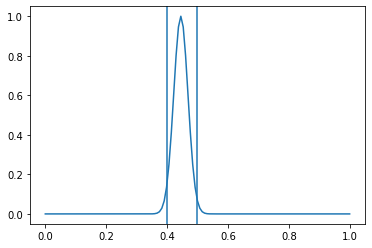

In [478]:
window_std = params.b / 4
window_center = params.a + params.b / 2
_, unit_response_ys = gaussian_window(window_center.item(), window_std.item(),
                                      sample_rate=sample_rate)
plt.plot(np.arange(len(unit_response_ys)) / sample_rate, unit_response_ys)
plt.axvline(params.a)
plt.axvline(params.a + params.b)

In [479]:
if STIM_SOURCE == "random":
    stim = stimulus.RandomStimulusGenerator()
elif STIM_SOURCE == "sentences":
    text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
""".strip()
    sentences = [s.strip().replace("\n", "") for s in re.split(r"[.?!]", text)]
    sentences = [s for s in sentences if s]
    
    phonemes = np.array(list("abcdefghijklmnopqrstuvwxyz_"))
    stim = partial(stimulus.NaturalLanguageStimulusGenerator(phonemes=phonemes, hf_model="gpt2"), sentences)

Using pad_token, but it is not set yet.


In [480]:
ds = gen.sample_dataset(params, stim,
                        response_type="gaussian")

  0%|          | 0/1 [00:00<?, ?it/s]

In [481]:
incremental_gt_probabilities = rr.predictive_model(ds.p_word, ds.candidate_phonemes, confusion=ds.params.confusion, lambda_=ds.params.lambda_)
incremental_gt_probabilities[:3]

tensor([[0.0083, 0.4702, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.9643, 0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.0141, 0.2670, 0.9748, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]])

In [482]:
next(iter(incremental_gt_probabilities))

tensor([0.0083, 0.4702, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

In [483]:
ds.phoneme_onsets[:3]

tensor([[0.0000, 0.1450, 0.3197, 0.3197, 0.3197, 0.3197, 0.3197, 0.3197, 0.3197,
         0.3197, 0.3197],
        [0.0000, 0.0810, 0.1811, 0.1811, 0.1811, 0.1811, 0.1811, 0.1811, 0.1811,
         0.1811, 0.1811],
        [0.0000, 0.1920, 0.3415, 0.4369, 0.5301, 0.6143, 0.7422, 0.9177, 1.0649,
         1.0649, 1.0649]])

In [484]:
ds.recognition_points

tensor([2, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0])

In [485]:
ds.word_onsets[:5]

tensor([1.3217, 2.0118, 2.5108, 3.6861, 4.0643])

(1.0, 10.0)

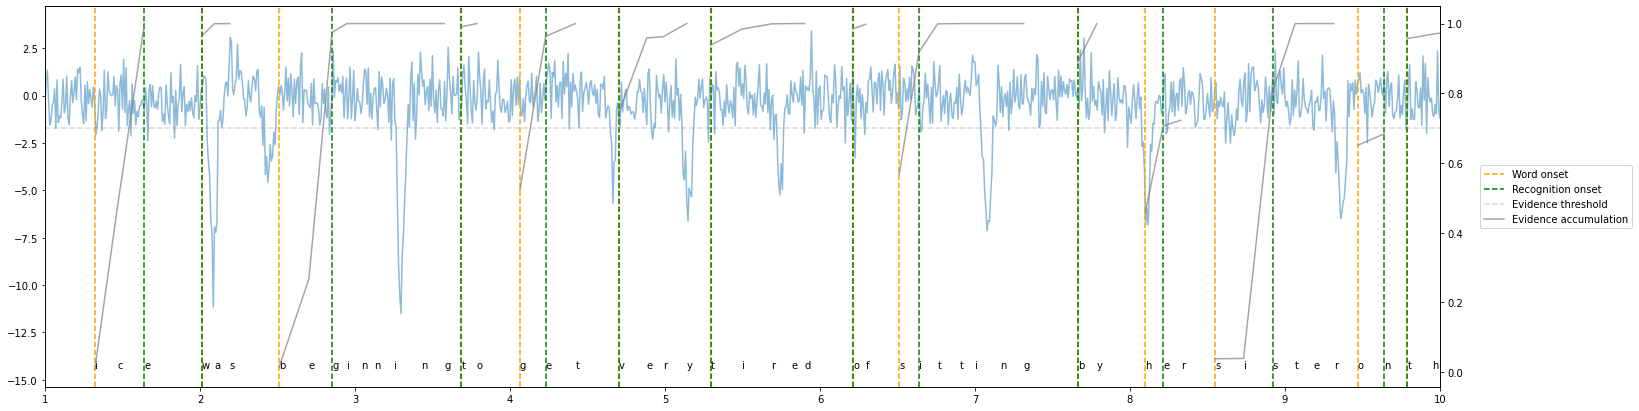

In [486]:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(np.arange(ds.Y.shape[0]) / ds.sample_rate, ds.Y[:, 0], alpha=0.5)

annot_height = ax.get_ylim()[0] + 1

# Annotate word onset and phonemes
for i, word_onset in enumerate(ds.word_onsets + ds.phoneme_onsets[:, 0]):
    h_onset = ax.axvline(word_onset, c="orange", linestyle="--")
    for j, phoneme_onset in enumerate(word_onset + ds.phoneme_onsets[i]):
        phon = ds.phonemes[ds.candidate_phonemes[i, 0, j]]
        if phon != "_":
            ax.annotate(phon, xy=(phoneme_onset, annot_height))
# Annotate recognition onset
for rec_onset in ds.word_onsets + ds.recognition_onsets:
    h_recognition = ax.axvline(rec_onset, c="green", linestyle="--")
    
# Annotate evidence climb to recognition
right_ax = ax.twinx()
h_threshold = right_ax.axhline(ds.params.threshold, c="gray", linestyle="--", alpha=0.3)
for i, (length, phoneme_onsets, incremental_gt_prob) in enumerate(zip(ds.word_lengths, ds.word_onsets[:, None] + ds.phoneme_onsets, incremental_gt_probabilities)):
    xs = phoneme_onsets[:length]
    ys = incremental_gt_prob[:length]
    h_evidence, = right_ax.plot(xs, ys, c="gray", alpha=0.7)

ax.legend([h_onset, h_recognition, h_threshold, h_evidence],
          ["Word onset", "Recognition onset", "Evidence threshold", "Evidence accumulation"],
          loc='center left', bbox_to_anchor=(1.025, 0.5))
    
ax.set_xlim((1, 10))

In [487]:
offsets = ((ds.recognition_onsets + ds.params.a - ds.epoch_window[0]).numpy() * ds.sample_rate).astype(int)
ds.Y_epoch[np.arange(len(ds.Y_epoch)), offsets + 3][:3]

tensor([[-4.2302],
        [-4.5772],
        [-5.4526]])

In [488]:
ds.p_word[:3, 0]

tensor([-6.3512, -2.9601, -6.7436])

In [489]:
ds.X_epoch[:3]

tensor([[1.0000, 9.1629],
        [1.0000, 4.2705],
        [1.0000, 9.7290]])

## N400 replication

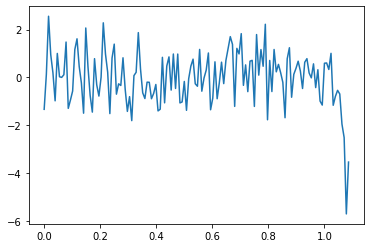

In [490]:
plt.plot(np.arange(ds.Y_epoch.shape[1]) / ds.sample_rate, ds.Y_epoch[3, :, 0])

In [491]:
y_df = pd.DataFrame(ds.Y_epoch.numpy().squeeze())
y_df.index.name = "cum_token_idx"
y_df.columns.name = "epoch_sample"
y_df = y_df.unstack().rename("signal").reset_index()
y_df["time"] = y_df.epoch_sample / ds.sample_rate + ds.epoch_window[0]

In [492]:
epoch_baselines = y_df[y_df.time <= 0].groupby("cum_token_idx").signal.mean()
y_df["signal_baselined"] = y_df.signal - y_df.cum_token_idx.map(epoch_baselines)

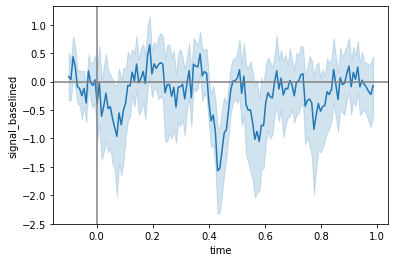

In [493]:
ax = sns.lineplot(data=y_df, x="time", y="signal_baselined")
ax.axvline(0, c="gray")
ax.axhline(0, c="gray")

### N400 replication

With ground-truth recognition onset information, can we reproduce an N400 effect with ERP analysis?

In [494]:
def time_window_to_sample(window, sample_rate, t_zero=0.):
    left, right = window
    
    left = int(np.floor((left - t_zero) * sample_rate))
    right = int(np.floor((right - t_zero) * sample_rate))
    return (left, right)

def compute_erp(dataset: rr.RRDataset,
                baseline_window=(-0.1, 0),
                test_window=None,
                use_recognition_onset=True
                ) -> pd.DataFrame:
    if test_window is None:
        test_window = (dataset.params.a, dataset.params.a + dataset.params.b)

    baseline_left_samp, baseline_right_samp = time_window_to_sample(baseline_window, dataset.sample_rate,
                                                                    t_zero=dataset.epoch_window[0])
    test_left_samp, test_right_samp = time_window_to_sample(test_window, dataset.sample_rate,
                                                            t_zero=dataset.epoch_window[0])
    
    if use_recognition_onset:
        recognition_onset_samp = np.floor(dataset.recognition_onsets * sample_rate).int().numpy()
        test_values = [dataset.Y_epoch[i, recognition_onset_samp_i + test_left_samp:recognition_onset_samp_i + test_right_samp, 0].mean()
                       for i, recognition_onset_samp_i in enumerate(recognition_onset_samp)]
        test_values = torch.stack(test_values)
    else:
        test_values = dataset.Y_epoch[:, test_left_samp:test_right_samp, 0].mean()
    
    baseline_values = dataset.Y_epoch[:, baseline_left_samp:baseline_right_samp, 0]

    return pd.DataFrame({"cum_token_idx": np.arange(len(dataset.Y_epoch)),
                         "baseline_value": baseline_values.mean(dim=1),
                         "test_value": test_values})

In [495]:
erp_df = compute_erp(ds)
erp_df["surprisal"] = ds.X_epoch[:, 1].numpy()

In [496]:
erp_df

,cum_token_idx,baseline_value,test_value,surprisal
0,0,-0.142785,-4.830921,9.162878
1,1,-0.439569,-2.583837,4.270475
2,2,-2.583837,-5.508037,9.729026
3,3,0.238365,0.075438,0.076606
4,4,-0.289729,-1.807000,3.613801
5,5,-1.701861,-3.716656,6.341489
6,6,-0.113600,-2.422615,3.437193
7,7,-0.170534,-0.411259,0.621716
8,8,0.465494,-4.283716,6.435883
9,9,0.400007,-3.527180,6.168333


In [497]:
erp_df.sort_values("surprisal", ascending=False)

,cum_token_idx,baseline_value,test_value,surprisal
35,35,0.186491,-8.008806,13.351555
33,33,-0.156762,-7.921778,12.773201
21,21,-0.283487,-5.729265,10.047056
2,2,-2.583837,-5.508037,9.729026
14,14,-0.507271,-5.859764,9.585514
0,0,-0.142785,-4.830921,9.162878
22,22,0.579891,-4.656886,8.271552
26,26,0.018651,-4.552627,7.703899
16,16,-2.004011,-4.588788,7.581099
12,12,-1.466534,-4.004820,6.927747


In [498]:
# baseline_window = (-.1, 0)
# test_window = (0.3, 0.5)
# df_test = epochs.groupby(["item", "token_idx"]).apply(
#     lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
#                             "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [499]:
# merged_df = pd.merge(df_test, raw_dataset.X_word, left_index=True, right_index=True)
# merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

In [500]:
erp_df["epoch_value_baselined"] = erp_df.test_value - erp_df.baseline_value

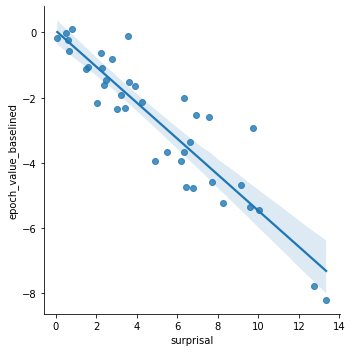

In [501]:
sns.lmplot(data=erp_df, x="surprisal", y="epoch_value_baselined")

In [502]:
st.pearsonr(erp_df.surprisal, erp_df.epoch_value_baselined)

(-0.9142563992417166, 1.0742875251036358e-15)